In [1]:
import pydicom # read dicom files
import os # do directory ops
import pandas as pd # data analysis
import numpy as np # array ops
import math
import cv2 # image processin


# plotting
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

data_dir = "./data/train/"
patients = os.listdir(data_dir)
train_df = pd.read_csv("./data/train.csv")

train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


begin to iterate through the patients and gather their respective data. We're almost certainly going to need to do some preprocessing of this data

In [2]:
for patient in patients[:5]:
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    patient_history_df = train_df[train_df.Patient == patient].sort_values(by="Weeks")
    print(len(slices), slices[0].pixel_array.shape)

31 (512, 512)
205 (512, 512)
253 (512, 512)
67 (512, 512)
106 (512, 512)


In [3]:
len(patients)

177

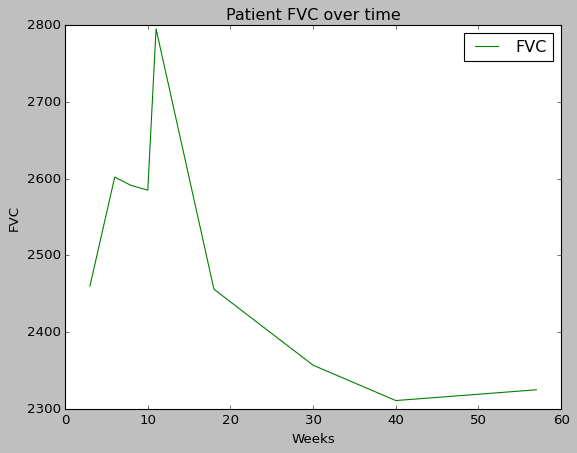

In [4]:
patient_history_df.plot(kind='line',x='Weeks',y='FVC',color='green')
plt.ylabel("FVC")
plt.title("Patient FVC over time")
plt.show()

## Resizing & Visualizing DICOM slices

In [105]:
IMG_PX_SIZE = 50
HM_SLICES = 10

def chunks(lst, n):
    # source link: https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def mean(l):
    return sum(l)/len(l)


def process_data(patient, patient_history_df, img_px_size=50, hm_slices=10, visualize=False):
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    # each scan is not the same depth (number of slices), we we group the slices into chunks of size HM_SLICES
    # and average across them to make sure the dimensionality is standardized
    
    new_slices = []
    
    slices = [cv2.resize(np.array(each_slice.pixel_array), (IMG_PX_SIZE, IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    # accounting for rounding errors by averaging the last slice or two if necessary
    if len(new_slices) == HM_SLICES - 1:
        new_slices.append(new_slices[-1])
    
    if len(new_slices) == HM_SLICES - 2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
    
    if len(new_slices) == HM_SLICES - 3:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
    
    if len(new_slices) == HM_SLICES - 4:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        
    if len(new_slices) == HM_SLICES + 2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1], new_slices[HM_SLICES]])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLIZES-1] = new_val
    
    if len(new_slices) == HM_SLICES + 2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1], new_slices[HM_SLICES]])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLIZES-1] = new_val
        
        
#     print(len(new_slices))
    
    
    if visualize:
        fig = plt.figure()
        for num, each_slice in enumerate(new_slices):
            y = fig.add_subplot(2, 5, num+1)
            y.imshow(each_slice, cmap="gray")
        plt.show()
    
    relevant_side_info = patient_history_df[["Patient", "Weeks", "FVC", "Percent"]]
    
    return np.array(new_slices), relevant_side_info
    
    

## Saving off DICOMS to disk with their associated "weeks" and "FVC" for training dataset aggregation

In [106]:
error_log = []
all_the_data = []

for num, patient in enumerate(patients):
    if num%10 == 0:
        print("Patient:" + str(num))
    patient_history_df = train_df[train_df.Patient == patient].sort_values(by="Weeks")
    
    try:
        img_data, patient_history = process_data(patient, patient_history_df, img_px_size=IMG_PX_SIZE, hm_slices=HM_SLICES)
        
        for index, row in patient_history.iterrows():
            all_the_data.append([img_data, row['Weeks'], row['FVC']])
            
    except Exception as e:
        error_log.append((patient, e))
        continue

# saving off the image data, associated weeks, and fvc to predict
# all images saved off as 50x50x10 3d volumes
np.save("allthedata-{}-{}-{}".format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), all_the_data)

Patient:0
Patient:10
Patient:20
Patient:30
Patient:40
Patient:50
Patient:60
Patient:70
Patient:80
Patient:90
Patient:100
Patient:110
Patient:120
Patient:130
Patient:140
Patient:150
Patient:160
Patient:170


I'm thinking we can use the baseline CT scan as the image in a 3D-CNN as part of a wide and deep network. We have side information (Age, Smoker Status, Gender) that we can feed into the wide part, and it will be conditioned on the "Weeks since baseline scan" as a final wide variable in the network.

The way we'd train the model is on tuples like (CT Scan, Weeks) --> FVC. Meaning for one patient, if they have 7 FVC measurements at different times, we'll have 7 training rows, 1 for each measurement, and the target is the FVC at that time.
- we may want to use FVC Percent instead of FVC, so we'll see
- this approach makes it questionable if we'll want to use measurements from before the scan (negative weeks)
- looking like we're going to want to use a significant amount of pre-processing here (besides simple resizing & translations to line shit up, we'll need to threshold and potentially segment the images further if we want to use full res images in some way)


Since the number of slices aren't the same per scan or per patient, we'll want to do some sort of "chunking" like I've done here to make sure we have the same depth of "slices" for each baseline scan.


## Building a Dumb CNN to take in an image and predict FVC

This doesn't include Weeks as a feature so we're feeding in the same 3D image with different FVC targets during training, so not expecting this to learn too much tbh. Just getting some tf into the repo :) 

In [107]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


IMG_PX_SIZE = 50
SLICE_COUNT = 10

def create_cnn(width=IMG_PX_SIZE, height=IMG_PX_SIZE, depth=SLICE_COUNT, filters=(16, 32, 64)):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth, 1)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)
    
    for (i, f) in enumerate(filters):
        # if this is the first Conv layer, then set the input appropriately
        if i == 0:
            x = inputs
        
        # Conv -> ReLU -> BN -> Pool
        x = Conv3D(f, (3, 3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling3D(pool_size=(2, 2, 2))(x)
        
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    
    # apply another FC layer
    x = Dense(4)(x)
    x = Activation("relu")(x)
    
    # regression node
    x = Dense(1, activation="linear")(x)
    
    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

model = create_cnn()
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [114]:
all_data = np.load('allthedata-50-50-10.npy', allow_pickle=True)
train_data = all_data[:-100]
validation_data = all_data[-100:]

train_x = np.stack(np.array(train_data[:, 0]))
train_x = np.moveaxis(train_x, 1, -1)
train_y = np.asarray(train_data[:, 2]).astype(np.float32)

val_x = np.stack(np.asarray(validation_data[:, 0]))
val_x = np.moveaxis(val_x, 1, -1)
val_y = np.asarray(validation_data[:, 2]).astype(np.float32)

In [117]:
train_x.shape

(1408, 50, 50, 10)

In [119]:
print("[INFO] training model...")
model.fit(x=train_x, y=train_y, 
    validation_data=(val_x, val_y),
    epochs=25, batch_size=8)

[INFO] training model...
Epoch 1/25
176/176 [==============================] - 69s 391ms/step - loss: 96.6311 - val_loss: 96.3805
Epoch 2/25
176/176 [==============================] - 68s 384ms/step - loss: 94.4585 - val_loss: 93.4070
Epoch 3/25
176/176 [==============================] - 68s 385ms/step - loss: 91.2099 - val_loss: 88.5762
Epoch 4/25
176/176 [==============================] - 67s 383ms/step - loss: 86.2802 - val_loss: 87.7991
Epoch 5/25
176/176 [==============================] - 68s 386ms/step - loss: 79.6559 - val_loss: 81.8186
Epoch 6/25
176/176 [==============================] - 68s 385ms/step - loss: 71.4035 - val_loss: 71.6468
Epoch 7/25
176/176 [==============================] - 68s 384ms/step - loss: 63.5164 - val_loss: 58.3141
Epoch 8/25
176/176 [==============================] - 68s 384ms/step - loss: 57.2926 - val_loss: 60.5917
Epoch 9/25
176/176 [==============================] - 68s 386ms/step - loss: 51.6203 - val_loss: 51.5672
Epoch 10/25
176/176 [=========

Text(0.5, 1.0, 'LOL seems about right')

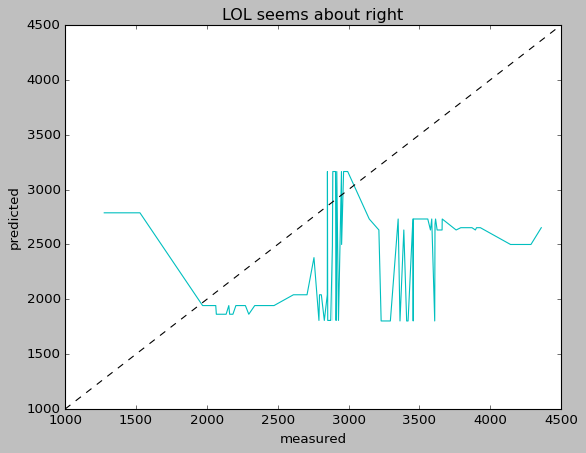

In [142]:
import seaborn as sns

preds = model.predict(val_x)
df = pd.DataFrame({'predicted': preds.flatten(), 'measured': val_y}).sort_values(by="measured")
sns.lineplot(x="measured", y="predicted", data=df, color='c')
slope1_x = range(1000, 4500, 1)
slope1_y = range(1000, 4500, 1)
plt.plot(test_x, test_y, '--k')
plt.title('LOL seems about right')